# **Assignment for Big Data Module 1**

"*Implementare un interpolatore lineare a tratti su una griglia a $n$ dimensioni.*

*Supporre che sia data la struttura dati multidimensionale $S_{j_0, \cdots, j_{n - 1}}$ che contiene il valore del campione della funzione nel punto della griglia di indici $j_0, \cdots, j_{n-1}$ e che il punto in cui calcolare l'interpolazione sia dato come un vettore $x_j$ con $n$ componenti.*"

Reference used: course lecture notes *4 - Interpolation*.

In [1]:
import numpy as np
np.random.seed(0)
from itertools import product # Cartesian product

Implementation of the convex decomposition of $\mathbf{x} \in [0, 1)^n$ into $n + 1$ pairs $(\mathbf{b}^j, \alpha_{\mathbf{b}^j})_{j = 0, \cdots, n}$ of:
*   selected vectors `b[j]` $= \mathbf{b}^j \in \mathbb{B}$, with $\mathbb{B} = \{0, 1\}^n$
*   corresponding coefficients `a[j]` $= {\alpha_{\mathbf{b}^j}} \ge 0$ s.t. ${\sum_{j = 0}^{n}} \alpha_{\mathbf{b}^j} = 1$.

In [2]:
def my_decomposition(x):
    
    n = len(x)          # dimension
    p = x.argsort()     # permutation that sorts x in ascending order
    B = np.concatenate( # B[j] will be the j-th vector of the basis
        (
            np.ones((n, n), dtype=bool),  # 1st one is all 1s; up to the n-th, they will be adjusted flipping down components
            np.zeros((1, n), dtype=bool), # last one is already known to be all 0s
        )
    )
    a = np.zeros(n + 1) # alpha coefficients: a[j] is the coeff of B[j]
    
    # decomposition algorithm
    a[0] = x[p[0]]
    for j in range(1, n):
        B[j:, p[j - 1]] = 0 # entry j is zeroed from this vector on
        a[j] = x[p[j]] - x[p[j - 1]]
    a[n] = 1 - a.sum()

    return p, B, a

Check of the correctness of the implementation: it must hold that $\mathbf{x} = {\sum_{j = 0}^{n}} \alpha_{\mathbf{b}^j} \mathbf{b}^j$.

That is, `np.dot(a, B)` must amount to `x` up to the numerical precision.

In [3]:
n = np.random.randint(1, 1 + 5, (1,)).item() # random dimension (max 5)
x = np.random.rand(n)                        # random vector in [0, 1)^n

p, B, a = my_decomposition(x)

aB = np.dot(a, B)                            # recomposition
d = ((aB - x)**2).sum()**0.5                 # Euclidean distance

# print a summary of the test
print('Vector:')
print('n = %d' % n)
print('x =', x)
print('\nDecomposition:')
print('p =', p)
print('B =')
print(B.astype(np.int))
print('a =', a)
print('\nCheck of the recomposition:')
print('  x =', x)
print('a*B =', aB)
print('\nTheoretical is 0. Numerical discrepancy: d =', d)

Vector:
n = 5
x = [0.59284462 0.84426575 0.85794562 0.84725174 0.6235637 ]

Decomposition:
p = [0 4 1 3 2]
B =
[[1 1 1 1 1]
 [0 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
a = [0.59284462 0.03071908 0.22070205 0.00298599 0.01069388 0.14205438]

Check of the recomposition:
  x = [0.59284462 0.84426575 0.85794562 0.84725174 0.6235637 ]
a*B = [0.59284462 0.84426575 0.85794562 0.84725174 0.6235637 ]

Theoretical is 0. Numerical discrepancy: d = 0.0


Implementation of `fhat` $= \hat{f}(\cdot)$ based on the data structure `S` $= S_{j_0, \cdots, j_{n - 1}}$:

Formula: $\hat{f}(\mathbf{x}) = {\sum_{j = 0}^{n}} \alpha_{\mathbf{b}^j} S_{z + \mathbf{b}^j}$.

In code: `fhat(x) = np.dot(a, S[z + B])`  (slight abuse of notation in accessing `S`).

In [4]:
def fhat(x, S):
    
    n = len(x)                     # dimension
    z = np.floor(x).astype(np.int) # vector integer part
    x = x - z                      # vector fractional part
    
    _, B, a = my_decomposition(x)
    
    #    z + B :    matrix: point z (broadcast) + ALL decomposition vectors b^j = B[j]
    #      zpb :    vector: point z + ONE decomposition vector b*j = B[j]
    #        S :    the data structure f(z grid)
    # S_zplusB :    S(z + B): matrix of the n+1 images of z + B looked up in S
    S_zplusB = np.array([S[tuple(zpb)] for zpb in z + B])
    
    return np.dot(a, S_zplusB) # linear interpolation formula

## Example 1
*   check on an integer vector
*   computation on a generic point

In [8]:
# The scalar function to be linearly interpolated
def f(x):
    return np.sin(x / 5).sum()

J = (10, 10, 20, 15) # number of grid points in each dimension
n = len(J)           # dimension

Zj = [np.arange(J[j]) for j in range(n)] # integer values in each dimension
grid_in_Zn = product(*Zj)                # grid: "rectangular" subset of Z^n
                                         # Cartesian product done via itertool.product

# creation of the grid of values S
S = np.zeros(J)
for z in grid_in_Zn:
    S[z] = f(np.array(z))

# A) Interpolation in a random integer point (inside the grid)
x_integral = np.random.randint(low=0, high=np.array(J) - 1, size=n) # random integral part
x = x_integral
fx, fhatx = f(x), fhat(x, S) # compute exact value and interpolated value
e = fhatx - fx               # interpolation error (signed)
# print summary of the test
print('Test on an integer vector:')
print('     x  =', x)
print('   f(x) =', fx)
print('fhat(x) =', fhatx)
print('Interpolation error must be 0. Interpolation error (signed): e = fhat(x) - f(x) =', e)

# B) Interpolation in a random point (inside the grid)
x_integral = np.random.randint(low=0, high=np.array(J) - 1, size=n) # random integral part
x_fractional = np.random.rand(n)                                    # random fractional part
x = x_integral + x_fractional
fx, fhatx = f(x), fhat(x, S) # compute exact value and interpolated value
e = fhatx - fx               # interpolation error (signed)
print('\nInterpolation in a generic point:')
print('     x  =', x)
print('   f(x) =', fx)
print('fhat(x) =', fhatx)
print('Interpolation error (signed): e = fhat(x) - f(x) =', e)

Test on an integer vector:
     x  = [0 1 9 9]
   f(x) = 2.1463645925514516
fhat(x) = 2.1463645925514516
Interpolation error must be 0. Interpolation error (signed): e = fhat(x) - f(x) = 0.0

Interpolation in a generic point:
     x  = [ 0.73691818  4.21655035  3.13521817 11.32414101]
   f(x) = 2.249125701561035
fhat(x) = 2.2413032668331603
Interpolation error (signed): e = fhat(x) - f(x) = -0.007822434727874583


## Example 2
One-dimensional case with plot.

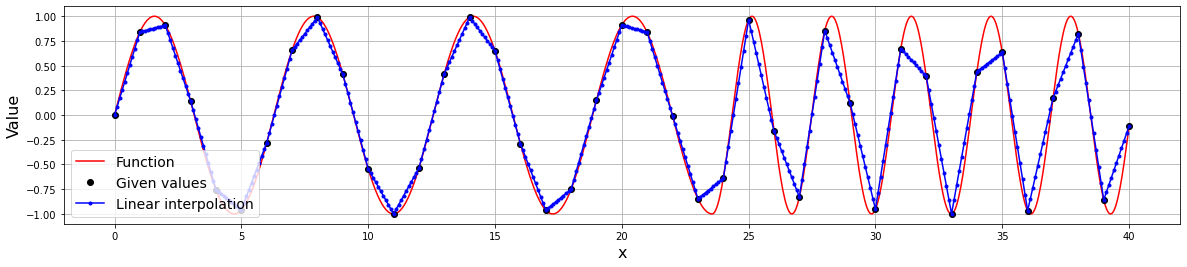

In [6]:
# The scalar function to be linearly interpolated
def f(x):
    t = 3.75 * 2 * np.pi
    return np.sin(x) if x < t else np.sin(2 * x + t + np.pi)

# dimension is n = 1
J = 42       # number of grid points
xmax = J - 2 # maximum x not to exceed the grid

grid_in_Z = np.arange(J)                # grid of integers
S = np.array([f(z) for z in grid_in_Z]) # creation of the grid of values S

M = 1 + (J - 2) * 10                        # number of points to interpolate in
x = np.linspace(0, xmax, M).reshape((M, 1)) # points to interpolate in
fhatx = np.array([fhat(xm, S) for xm in x]) # compute the interpolated values


# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))

xf = np.linspace(0, xmax, 1000) # exact values woth finer resolution also in x, for the plot
plt.plot(xf, [f(xx) for xx in xf], 'r-', label='Function')

zticks = range(0, J - 1)
plt.plot(zticks, [f(z) for z in zticks], 'ko', label='Given values')

plt.plot(x, fhatx, 'b.-', label='Linear interpolation')

plt.legend(loc='lower left', fontsize=14)
plt.xlabel('x', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.grid()